<a href="https://colab.research.google.com/github/gparedesg/proyecto-integrador/blob/master/BERT%2BCFDI_AJC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Entrenamiento de código de Productos y Servicios**

Para cada producto o servicio que queda en una factura timbrada en México tiene las mismas características. Debe llevar un código CFDI y una unidad CFDI asociada. Por ejemplo, un negocio que es un bar y vende alcohol puede tener en su menú tequila, mezcal, cerveza y ron. Puede venderlo en botellas, shots, jarras y vasos. Supongamos que hay un cliente que quiere comprar varios shots de mezcal. Si el cliente se llevó 3, entonces:

3 shot (unidad 14) de Mezcal (código 50202206)

Esta libreta busca entrenar el modelo de los códigos de producto y servicio únicamente, pues es la base de datos más extensa de las dos.

In [20]:
!pip install tensorflow

In [21]:
!pip install nltk

In [22]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.utils import resample

In [23]:
df = pd.read_csv("/content/cfdi.csv")
print(df.head(5))

       code               description             similar       type  \
0   1010101  No existe en el catálogo  Público en general        NaN   
1  10101500  Animales vivos de granja                 NaN  Productos   
2  10101501               Gatos vivos                 NaN  Productos   
3  10101502                    Perros                 NaN  Productos   
4  10101504                     Visón                 NaN  Productos   

                                            division           group  
0                                                NaN             NaN  
1  Material Vivo Vegetal y Animal, Accesorios y S...  Animales vivos  
2  Material Vivo Vegetal y Animal, Accesorios y S...  Animales vivos  
3  Material Vivo Vegetal y Animal, Accesorios y S...  Animales vivos  
4  Material Vivo Vegetal y Animal, Accesorios y S...  Animales vivos  


En esta base de datos actualizada, tenemos además de la columna de frases similares, dos nuevas columnas para apoyarnos con el entrenamiento. Hay una división y un grupo, que se comportan como categoría y subcategoría dentro del catálogo CFDI.

In [24]:
df['group'].unique()

array([nan, 'Animales vivos', 'Productos para animales domésticos',
       'Comida de animales', 'Recipientes y hábitat para animales',
       'Productos de talabartería y arreo',
       'Semillas, bulbos, plántulas y esquejes',
       'Productos de floricultura y silvicultura',
       'Fertilizantes y nutrientes para plantas y herbicidas',
       'Productos para el control de plagas', 'Rosales vivos',
       'Plantas vivas de especies o variedades de flores altas',
       'Plantas vivas de especies o variedades de flores bajas',
       'Crisantemos vivos', 'Claveles vivos', 'Orquídeas vivas',
       'Rosas frescas cortadas',
       'Bouquets cortados frescos de especies o variedades de flores altas',
       'Bouquets cortados frescos de especies o variedades de flores bajas',
       'Crisantemos cortados frescos',
       'Bouquets florales cortados frescos', 'Claveles cortados frescos',
       'Orquídeas cortadas frescas', 'Rosas cortadas secas',
       'Bouquets cortados secos de esp

In [25]:
df['division'].unique()

array([nan, 'Material Vivo Vegetal y Animal, Accesorios y Suministros',
       'Material Mineral, Textil y Vegetal y Animal No Comestible',
       'Material Químico incluyendo Bioquímicos y Materiales de Gas',
       'Materiales de Resina, Colofonia, Caucho, Espuma, Película y Elastómericos',
       'Materiales y Productos de Papel',
       'Materiales Combustibles, Aditivos para Combustibles, Lubricantes y Anticorrosivos',
       'Maquinaria y Accesorios de Minería y Perforación de Pozos',
       'Maquinaria y Accesorios para Agricultura, Pesca, Silvicultura y Fauna',
       'Maquinaria y Accesorios para Construcción y Edificación',
       'Maquinaria y Accesorios para Manufactura y Procesamiento Industrial',
       'Maquinaria, Accesorios y Suministros para Manejo, Acondicionamiento y Almacenamiento de Materiales',
       'Vehículos Comerciales, Militares y Particulares, Accesorios y Componentes',
       'Maquinaria y Accesorios para Generación y Distribución de Energía',
       'Her

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52512 entries, 0 to 52511
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         52512 non-null  int64 
 1   description  52512 non-null  object
 2   similar      12201 non-null  object
 3   type         52511 non-null  object
 4   division     52510 non-null  object
 5   group        52511 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.4+ MB


Podemos observar que de los 52,512 productos o servicios, solamente 12,201 tienen una frase similar proporcionada por el SAT.

In [27]:
# Función para limpiar stopwords

nltk.download('stopwords')
nltk.download('punkt')
stopwords_es = set(stopwords.words('spanish'))
'''
stopwords_es.add('suministros')
stopwords_es.add('materiales')
stopwords_es.add('equipos')
stopwords_es.add('servicios')
stopwords_es.add('maquinaria')
stopwords_es.add('componentes')
stopwords_es.add('vivo')
'''

def preprocesamiento_texto(texto):
  if texto:
    texto_sin_puntuacion = re.sub(r'[^\w\s]', '', texto)
    palabras = word_tokenize(texto_sin_puntuacion)
    palabras_filtradas = [palabra for palabra in palabras if palabra.lower() not in stopwords_es]
    return str(" ".join(palabras_filtradas))
  else:
    return ""

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
df[['description', 'division']] = df[['description', 'division']].replace('', np.nan)

df_filtered = df.dropna(subset=['description', 'division'])

# Aplicar el preprocesamiento
#df.loc[:, 'description'] = df['descripcion'].apply(preprocesamiento_texto)
#df.loc[:, 'group'] = df['group'].apply(preprocesamiento_texto)
#df_filtered['descripcion'].apply(preprocesamiento_texto)
#df_filtered['group'].apply(preprocesamiento_texto)

df_filtered.head(5)

,code,description,similar,type,division,group
1,10101500,Animales vivos de granja,NaN,Productos,"Material Vivo Vegetal y Animal, Accesorios y S...",Animales vivos
2,10101501,Gatos vivos,NaN,Productos,"Material Vivo Vegetal y Animal, Accesorios y S...",Animales vivos
3,10101502,Perros,NaN,Productos,"Material Vivo Vegetal y Animal, Accesorios y S...",Animales vivos
4,10101504,Visón,NaN,Productos,"Material Vivo Vegetal y Animal, Accesorios y S...",Animales vivos
5,10101505,Ratas,NaN,Productos,"Material Vivo Vegetal y Animal, Accesorios y S...",Animales vivos


In [29]:
df_filtered['description'] = df_filtered['description'].apply(preprocesamiento_texto)
df_filtered['division'] = df_filtered['division'].apply(preprocesamiento_texto)


df_filtered['division'].unique()

<ipython-input-29-04b19fc7a1ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['description'] = df_filtered['description'].apply(preprocesamiento_texto)
<ipython-input-29-04b19fc7a1ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['division'] = df_filtered['division'].apply(preprocesamiento_texto)


array(['Material Vivo Vegetal Animal Accesorios Suministros',
       'Material Mineral Textil Vegetal Animal Comestible',
       'Material Químico incluyendo Bioquímicos Materiales Gas',
       'Materiales Resina Colofonia Caucho Espuma Película Elastómericos',
       'Materiales Productos Papel',
       'Materiales Combustibles Aditivos Combustibles Lubricantes Anticorrosivos',
       'Maquinaria Accesorios Minería Perforación Pozos',
       'Maquinaria Accesorios Agricultura Pesca Silvicultura Fauna',
       'Maquinaria Accesorios Construcción Edificación',
       'Maquinaria Accesorios Manufactura Procesamiento Industrial',
       'Maquinaria Accesorios Suministros Manejo Acondicionamiento Almacenamiento Materiales',
       'Vehículos Comerciales Militares Particulares Accesorios Componentes',
       'Maquinaria Accesorios Generación Distribución Energía',
       'Herramientas Maquinaria General',
       'Componentes Suministros Estructuras Edificación Construcción Obras Civiles',
 

In [30]:
label_encoder = LabelEncoder()

df_filtered['division_encoded'] = label_encoder.fit_transform(df_filtered['division'])

df_filtered.head(10)


<ipython-input-30-7cbb1c066af0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['division_encoded'] = label_encoder.fit_transform(df_filtered['division'])


,code,description,similar,type,division,group,division_encoded
1,10101500,Animales vivos granja,NaN,Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
2,10101501,Gatos vivos,NaN,Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
3,10101502,Perros,NaN,Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
4,10101504,Visón,NaN,Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
5,10101505,Ratas,NaN,Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
6,10101506,Caballos,"Equinos, Potrancas, Potras, Potrillos, Potros,...",Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
7,10101507,Ovejas,"Borregos, Carneros",Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
8,10101508,Cabras,"Borregos cimarrones, Cabritos, Cabros, Carnero...",Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
9,10101509,Asnos,"Borricos, Burros",Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26
10,10101510,Ratones,NaN,Productos,Material Vivo Vegetal Animal Accesorios Sumini...,Animales vivos,26


In [31]:
encoding_table = pd.DataFrame({
    'Original': label_encoder.classes_,
    'Encoded': label_encoder.transform(label_encoder.classes_)
})

# Mostrar la tabla de codificación
encoding_table

,Original,Encoded
0,Alimentos Bebidas Tabaco,0
1,Artículos Domésticos Suministros Productos Ele...,1
2,Componentes Accesorios Suministros Sistemas El...,2
3,Componentes Equipos Distribución Sistemas Acon...,3
4,Componentes Suministros Electrónicos,4
5,Componentes Suministros Estructuras Edificació...,5
6,Componentes Suministros Manufactura,6
7,Difusión Tecnologías Información Telecomunicac...,7
8,Equipo Médico Accesorios Suministros,8
9,Equipos Limpieza Suministros,9


In [32]:
#Comenzamos a crear el modelo
'''
classes = df_filtered['division_encoded'].unique()
df_balanced = pd.DataFrame()
for cls in classes:
    df_class = df_filtered[df_filtered['division_encoded'] == cls]
    if len(df_class) < df_filtered['division_encoded'].value_counts().max():
        df_class = resample(df_class,
                           replace=True,
                           n_samples=df_filtered['division_encoded'].value_counts().max(),
                           random_state=0)
    df_balanced = pd.concat([df_balanced, df_class])

# Actualizar el DataFrame filtrado
df_filtered = df_balanced
'''

data_texts = df_filtered['description'].to_list()
data_labels = df_filtered['division_encoded'].to_list()

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# Keep some data for inference (testing)
#train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

Se decidió usar 'distilbert-base-multilingual-cased' pero queremos buscar si existe un branch o alguna otra opción en Español.

**Actualización 10 Oct**

Éste primer entrenamiento del modelo entregó un resultado de accuracy muy bajo, alrededor del 2%. Tras este resultado, decidimos cambiar la estrategia de predicción y pasar de la búsqueda de clases a una nueva división de los datos.

Utilizando el modelo BETO, que funciona mejor para el Español, además de un ajuste de hiperparámetros, lo que incrementó la precisión del modelo al 34%.

Los ajustes en el modelo:

* Modificaciones en el batch size
* Cambios en el preprocesamiento de datos (normalización, tokenización y otros)
* Ajustes en el Learning rate y épocas de entrenamiento

In [33]:
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
#train_encodings = tokenizer(train_texts, truncation=True, padding=True)
#val_encodings = tokenizer(val_texts, truncation=True, padding=True)

from transformers import TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from transformers import AdamW

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

loss_fn = SparseCategoricalCrossentropy(from_logits=True)



model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=56)
model.compile(optimizer='adamw', loss=loss_fn, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Preprocesar los textos: tokenización
def tokenize_function(text):
    tokenized = tokenizer(
        text if isinstance(text, str) else text.numpy().decode('utf-8'),  # Asegurarse de que el texto sea un str
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='tf'
    )
    # The tokenizer is returning a 2D tensor, so we need to remove the extra dimension
    # Using squeeze to remove the extra dimension from both input_ids and attention_mask
    return tf.squeeze(tokenized['input_ids']), tf.squeeze(tokenized['attention_mask'])
    #return tokenized['input_ids'][0], tokenized['attention_mask'][0]  # Using squeeze to remove extra dimension

# Crear datasets de entrenamiento y validación
def tokenize_map_function(text, label):
    input_ids, attention_mask = tf.py_function(func=tokenize_function, inp=[text], Tout=[tf.int32, tf.int32])
    input_ids.set_shape([64])
    attention_mask.set_shape([64])
    return {'input_ids': input_ids, 'attention_mask': attention_mask}, label

In [35]:
# Crear los datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))

# Aplicar la tokenización a los datasets
train_dataset = train_dataset.map(tokenize_map_function, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(tokenize_map_function, num_parallel_calls=tf.data.AUTOTUNE)

# Aplicar shuffle, batch y prefetch para optimizar el entrenamiento
train_dataset = train_dataset.shuffle(10).batch(50).prefetch(tf.data.AUTOTUNE)  # Aumentar el tamaño del lote para mejorar la eficiencia
val_dataset = val_dataset.batch(50).prefetch(tf.data.AUTOTUNE)

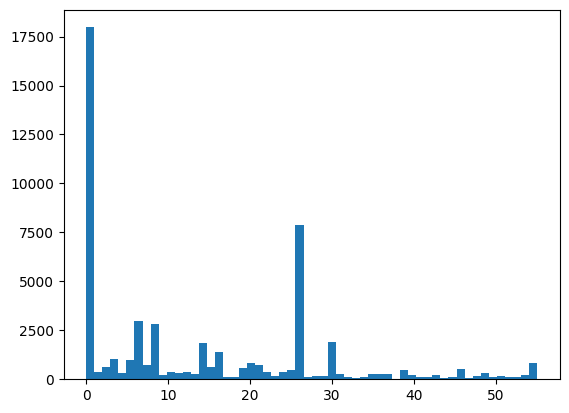

In [36]:
import matplotlib.pyplot as plt
plt.hist(data_labels, bins=56)
plt.show()

In [37]:
# Entrenar el modelo con monitoreo manual para Early Stopping
best_val_loss = float('inf')
patience = 3
wait = 0
num_epochs = 3

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Entrenar una época
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=1)
    val_loss = history.history['val_loss'][0]

    # Monitorear la pérdida de validación para Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        # Guardar los mejores pesos
        model.save_weights('best_model_weights')
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping triggered')
            model.load_weights('best_model_weights')
            break

Epoch 1/3
841/841 [==============================] - 662s 700ms/step - loss: 2.8022 - accuracy: 0.3385 - val_loss: 2.7914 - val_accuracy: 0.3421
Epoch 2/3
841/841 [==============================] - 584s 695ms/step - loss: 2.7844 - accuracy: 0.3417 - val_loss: 2.7790 - val_accuracy: 0.3421
Epoch 3/3
841/841 [==============================] - 585s 695ms/step - loss: 2.7722 - accuracy: 0.3422 - val_loss: 2.7695 - val_accuracy: 0.3421


In [38]:
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [39]:
def preprocess_texts(texts):
    tokenized_inputs = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=16,
        return_tensors='tf'
    )
    return tokenized_inputs

def get_original(encoded_value):
    result = encoding_table.loc[encoding_table['Encoded'] == encoded_value, 'Original']
    if not result.empty:
        return result.values[0]
    else:
        return None

# Tokenizar los textos de prueba
test_inputs = preprocess_texts(test_texts)

# Generar predicciones
predictions = model.predict(test_inputs)

# Interpretar las predicciones
predicted_labels = np.argmax(predictions.logits, axis=1)

# Mostrar resultados
for i, text in enumerate(test_texts):
    print(f"Texto: {text}")
    print(f"Etiqueta predicha: {get_original(predicted_labels[i])}")
    print("-----")

14/14 [==============================] - 3s 50ms/step
Texto: Takju vino arroz coreano
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Cocombro japonés enlatado envasado
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Ruibarbo timperley temprano orgánico seco
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Brunia viva albiflora
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Frascos cultivo tejidos
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Breva misión lata frasco
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Ajo ramson
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Abutillón
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Clorhidrato mecamilamina
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Conchas protectores senos
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Llaves macho mango t
Etiqueta predicha: Alimentos Bebidas Tabaco
-----
Texto: Iris cortada seca telstar
Etiqueta predicha: A

Guardado e importación del modelo

In [40]:
# Procedemos a guardar el modelo
from tensorflow.keras.models import load_model
save_directory = "Multitext_Classification"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('Multitext_Classification/tokenizer_config.json',
 'Multitext_Classification/special_tokens_map.json',
 'Multitext_Classification/vocab.txt',
 'Multitext_Classification/added_tokens.json')

In [41]:
# Para reusar el modelo lo cargamos

save_directory = "Multitext_Classification"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at Multitext_Classification were not used when initializing TFDistilBertForSequenceClassification: ['dropout_75', 'bert']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to b

In [44]:
# Generamos una predicción

predict_input = loaded_tokenizer.encode("servicios de desarrollo de software",
truncation=True,
padding=True,
return_tensors="tf")

#output = loaded_model(predict_input)[0]
output = model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
print("Encoded Group:" + str(prediction_value))

Encoded Group:0


In [45]:
# Función para obtener el valor original dado un valor codificado
def get_original(encoded_value):
    result = encoding_table.loc[encoding_table['Encoded'] == encoded_value, 'Original']
    if not result.empty:
        return result.values[0]
    else:
        return None

original_value = get_original(prediction_value)
print(f'El valor original correspondiente a {prediction_value} es: {original_value}')

El valor original correspondiente a 0 es: Alimentos Bebidas Tabaco


**Conclusiones y siguientes pasos**

El uso de Colab Pro: Para optimizar los tiempos de entrenamiento, se migró el proceso a Colab Pro, aprovechando la disponibilidad de GPUs más potentes como las de T4. Esto permitió reducir el tiempo de procesamiento a la mitad, pero no influyó significativamente en los resultados del modelo.

**Problemas encontrados**

A pesar de los cambios realizados, el modelo no fue capaz de superar el 34% de accuracy. Entre los posibles factores que podrían haber afectado el rendimiento se encuentran:

1. Preprocesamiento inadecuado: Es posible que el preprocesamiento actual de los datos no sea adecuado para el tipo de clasificación que intentamos realizar. Algunos métodos de tokenización o de limpieza de los datos podrían estar perdiendo información importante.

2. Ajustes de Hiperparametros insuficientes: A pesar de los intentos de ajuste del batch size y otros parámetros, el modelo parece estar estancado en su capacidad para mejorar la precisión.

3. Limitaciones del datasheet: Podría haber un problema inherente en el datasheet utilizado, como clases desbalanceadas, ruido en los datos o falta de representatividad en las características relevantes para la clasificación.

**Siguientes pasos**

1. Cambios en el preprocesamiento de los datos: Se considera hacer una revisión más profunda del preprocesamiento, con especial enfoque en el balanceo de clases, la tokenización y la normalización.

2. Nueva estrategia de división de clases: Se cambiará el enfoque hacia predecir en “División” como nuevo objetivo y luego aplicar las lecciones aprendidas para mejorar la precisión general.

3. Exploración de otros modelos y técnicas: Si BETO sigue mostrando limitaciones, exploraremos otras alternativas, como la utilización de modelos diferentes o la incorporación de técnicas de ensamble.

**Conclusiones**

El trabajo con el modelo BETO y el ajuste de Hiperparametros hasta la fecha ha demostrado ser desafiante, con un accuracy máximo de 34%. A pesar de los esfuerzos por mejorar los resultados mediante ajustes en el procesamiento de datos y el uso de hardware más potente, los resultados no mejoraron de manera significativa. El próximo paso será revisar de nuevo el preprocesamiento y cambiar la estrategia de predicción antes de intentar más modificaciones en los Hiperparametros o probar con otros modelos.